# Introduction to Random Forests

## Prerequisites

* Preliminaries:
    * Classification
    * Decision Trees

* For Scorecard Extension:
    * Logistic Regression
    * One-Hot Encoding

## Learning Goals

By the end of this lecture a student should be able to:

* Explain why forests are less prone to overfitting than trees.
* Explain why forests are less interpretable than trees.
* Create a random forest classifier.
* Tune the hyper-parameters of a classifier.

Above and Beyond:

* Explain how Forest-Encoding works.
* Explain why Forest-Encoding is a natural choice for Feature Engineering with GLMs such as Logistic Regression.

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from mlxtend.data import three_blobs_data
from sklearn.datasets import make_moons, make_circles, make_classification

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

rng = np.random.RandomState(42)

import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(self.forest.apply(X))
    

# Examples

## Circles

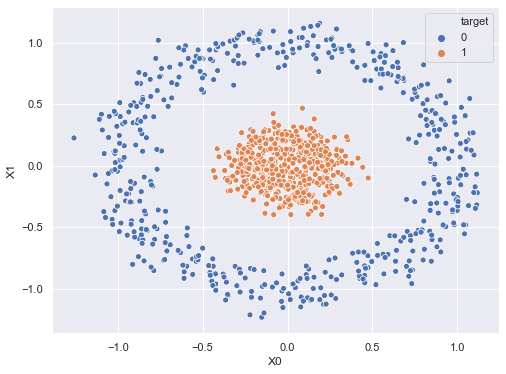

In [3]:
X, y = make_circles(n_samples=1000, random_state=42, 
                    noise=0.1, factor=0.2)

x0, x1 = 'X0', 'X1'
df_circles = pd.DataFrame(X, columns=[x0, x1])
target = 'target'
df_circles[target] = y

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_circles[x0], y=df_circles[x1], 
                hue=df_circles[target])
plt.show()

## Too Many Dimensions to Visualize (X: 10-dimensions)

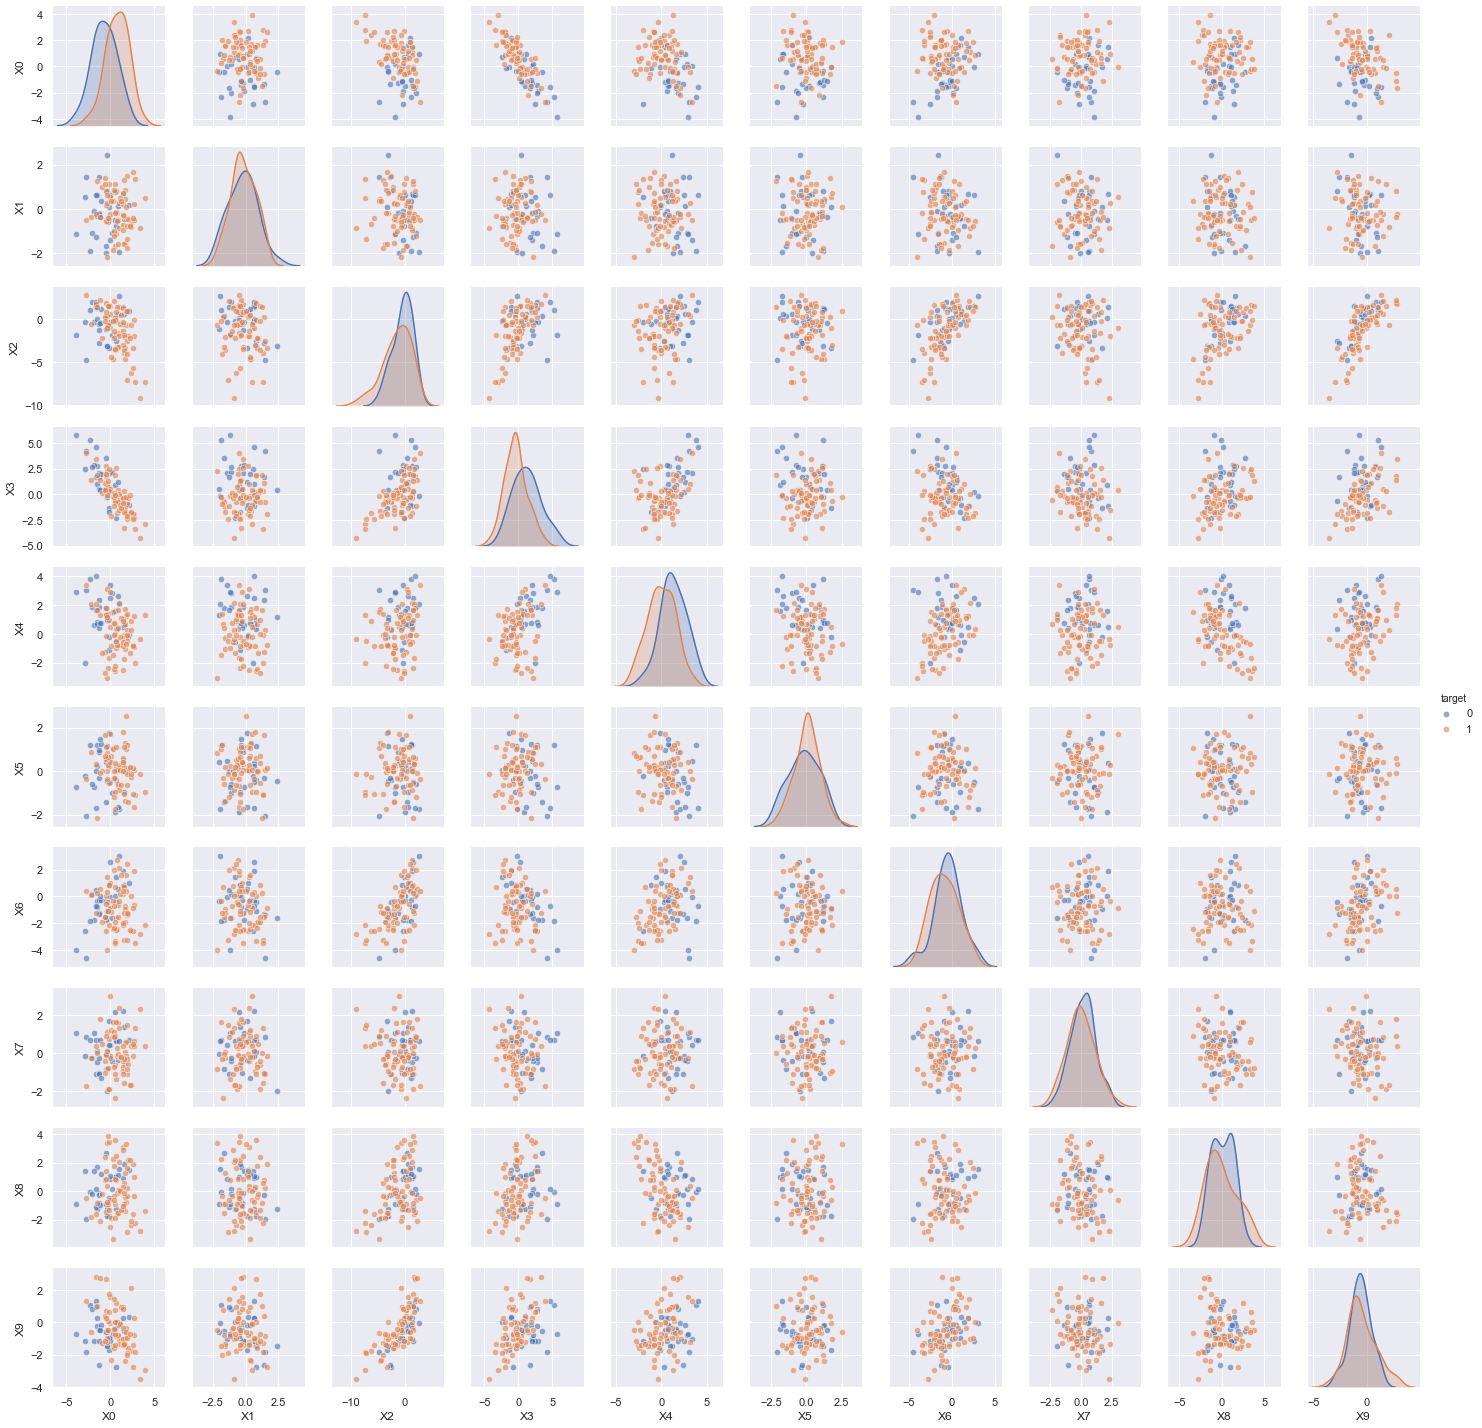

In [4]:
X, y = make_classification(n_samples=1000, 
                           n_features=10, n_informative=5, n_redundant=2, 
                           n_classes=2, n_clusters_per_class=3, 
                           weights=[0.3], random_state=42)


cols = ["X"+str(i) for i in range(10)]
df_10 = pd.DataFrame(X, columns=cols)
target = 'target'
df_10[target] = y

samp = df_10.sample(100)

sns.pairplot(samp, vars=cols, 
             hue=target, diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 40},
             height=2)
plt.show()

## Leaf-Scorecard Baseline (from Previous Lesson)

You'll notice the score is a bit different... but that is because we *cheated* previously. We had some **target leakage** -which we are now preventing by including our feature engineering in our CV-pipeline.

In [5]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

dt = DecisionTreeClassifier(class_weight='balanced', 
                            max_depth=4, criterion='entropy', 
                            min_samples_split=5)

encoder = ForestEncoder(dt)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8962619047619048 +/- 0.020997799798356986


# Forests: Bagging Weak Learners

## Random Forests - Bagged Decision Trees

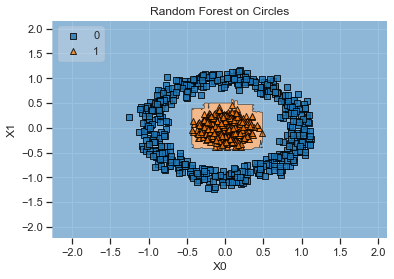

In [6]:
used_cols = [c for c in df_circles.columns.tolist() if c not in [target]]
X, y = df_circles[used_cols].values, df_circles[target].values

# Training a classifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X, y)

# Plotting decision regions
plot_decision_regions(X, y, clf=rf, legend=2)

# Adding axes annotations
plt.xlabel(x0)
plt.ylabel(x1)
plt.title('Random Forest on Circles')
plt.show()

## Extra Trees - Bagged Decision Trees

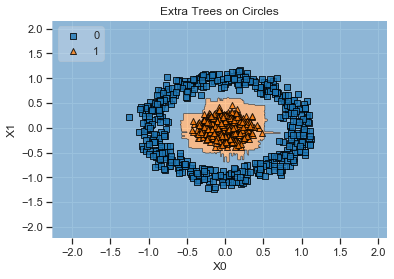

In [7]:
used_cols = [c for c in df_circles.columns.tolist() if c not in [target]]
X, y = df_circles[used_cols].values, df_circles[target].values

# Training a classifier
rf = ExtraTreesClassifier(n_jobs=-1, random_state=42)
rf.fit(X, y)

# Plotting decision regions
plot_decision_regions(X, y, clf=rf, legend=2)

# Adding axes annotations
plt.xlabel(x0)
plt.ylabel(x1)
plt.title('Extra Trees on Circles')
plt.show()

## Forest-Scorecard

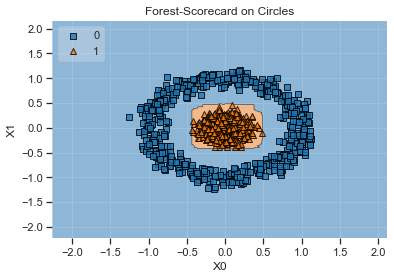

In [8]:
used_cols = [c for c in df_circles.columns.tolist() if c not in [target]]
X, y = df_circles[used_cols].values, df_circles[target].values

n_trees = 50
rf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1, random_state=42)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X, y)

# Plotting decision regions
plot_decision_regions(X, y, clf=pipe, legend=2)

# Adding axes annotations
plt.xlabel(x0)
plt.ylabel(x1)
plt.title('Forest-Scorecard on Circles')
plt.show()

# Forest-Scorecards on the Orignal Problem

## Random Forest

In [11]:
from joblib import Parallel, delayed
import math

Parallel(n_jobs=2, prefer="threads")(delayed(math.sqrt)(i ** 2) for i in range(10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [16]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

n_trees = 50
rf = RandomForestClassifier(n_estimators=n_trees, criterion='entropy', 
                            max_depth=8, min_samples_leaf=5, random_state=42, 
                            class_weight='balanced', n_jobs=1)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9419285714285713 +/- 0.012728946425274406


## Forest-Scorecard

In [17]:
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9527857142857142 +/- 0.016486887526681933


## Extra-Trees

In [19]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

n_trees = 50
rf = ExtraTreesClassifier(n_estimators=n_trees, criterion='entropy', 
                            max_depth=8, min_samples_leaf=5, random_state=42, 
                            class_weight='balanced', n_jobs=1)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9278333333333333 +/- 0.014575318497276543


## Extra-Scorecard

In [20]:
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9452619047619049 +/- 0.015034239078556711


# Hyper-Parameter Tuning

## Baseline

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.9272619047619047

## Tuning via GridSearch

In [29]:
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2', 0.2],
          "max_depth": [4, 6, 10],
          "min_samples_split": [2, 5, 10],
          "min_samples_leaf": [1, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'criterion'

In [30]:
grid_search.best_score_

0.9402157738095239

In [31]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

In [32]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.930952380952381

In [33]:
n_trees = best_rf.get_params()['n_estimators']

scores = cross_val_score(best_rf, X, y, cv=5, scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())

0.944452380952381 +/- 0.015662541069180445


In [34]:
encoder = ForestEncoder(best_rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9531428571428571 +/- 0.01798692520855218


## Tuning via HyperOpt

In [39]:
def auc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5).mean()


param_dict = {
    'max_depth': range(2, 20),
    'max_features': range(1, len(used_cols)+1),
    'n_estimators': range(30, 200),
    'criterion': ["gini", "entropy"],
    'min_samples_split': range(2, 20), # FRK: had to change this from 1->2
    'min_samples_leaf': range(1, 20)
}

param_space = {
    'max_depth': hp.choice('max_depth', param_dict['max_depth']),
    'max_features': hp.choice('max_features', param_dict['max_features']),
    'n_estimators': hp.choice('n_estimators', param_dict['n_estimators']),
    'criterion': hp.choice('criterion', param_dict['criterion']),
    'min_samples_split': hp.choice('min_samples_split', param_dict['min_samples_split']),
    'min_samples_leaf': hp.choice('min_samples_leaf', param_dict['min_samples_leaf'])
}

best = 0
def f(params):
    global best
    auc = auc_model(params)
    if auc > best:
        best = auc
    print ('new best:', best, params)
    return {'loss': -auc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

new best:                                              
0.867875744047619                                      
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 117}
new best:                                                                        
0.9064732142857143                                                               
{'criterion': 'gini', 'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 194}
new best:                                                                         
0.9083333333333332                                                                
{'criterion': 'gini', 'max_depth': 18, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 19, 'n_estimators': 91}
new best:                                                                         
0.9083333333333332                                                                
{'criterion

new best:                                                                         
0.942485119047619                                                                 
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 129}
new best:                                                                         
0.942485119047619                                                                 
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 129}
new best:                                                                         
0.942485119047619                                                                 
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 66}
new best:                                                                         
0.942485119047619               

{'criterion': 'gini', 'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 11, 'n_estimators': 68}
new best:                                                                         
0.942485119047619                                                                 
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 19, 'min_samples_split': 3, 'n_estimators': 54}
new best:                                                                         
0.942485119047619                                                                 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 7, 'min_samples_split': 14, 'n_estimators': 74}
new best:                                                                         
0.942485119047619                                                                 
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimator

0.945796130952381                                                                 
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 19, 'n_estimators': 183}
new best:                                                                         
0.945796130952381                                                                 
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 96}
new best:                                                                         
0.945796130952381                                                                 
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 62}
new best:                                                                         
0.945796130952381                                                                 
{'criterion': 'gini', 'max_depth

In [40]:
results = []
for i in range(100):
    result = trials.trials[i]['result']['loss']
    results.append(result)

In [41]:
best_results = []
for i, result in enumerate(results):
    if result <= -0.943:
        print(i, ":", result)
        best_results.append((i, result))

66 : -0.9448660714285715
67 : -0.9440104166666666
69 : -0.945796130952381
80 : -0.9432291666666666


In [42]:
example = 69
trials.trials[example]['misc']['vals']

{'criterion': [1],
 'max_depth': [8],
 'max_features': [3],
 'min_samples_leaf': [3],
 'min_samples_split': [2],
 'n_estimators': [58]}

In [43]:
best

{'criterion': 1,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 58}

In [44]:
best_params = {}
for key in best:
    val = param_dict[key][best[key]]
    print(key, ":", val)
    best_params[key] = val

criterion : entropy
max_depth : 10
max_features : 4
min_samples_leaf : 4
min_samples_split : 4
n_estimators : 88


In [48]:
rf = RandomForestClassifier(**best_params)
rf.set_params(n_jobs=1)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=88, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [49]:
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.9285714285714286

In [50]:
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())

0.9482380952380952 +/- 0.014758524958711649


In [51]:
n_trees = rf.get_params()['n_estimators']

encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9569761904761904 +/- 0.017782797618948003


# Feature Importances via Trees

Feature ranking:
1. feature 0 (0.230491)
2. feature 8 (0.163089)
3. feature 9 (0.157944)
4. feature 3 (0.111611)
5. feature 4 (0.107377)
6. feature 2 (0.085109)
7. feature 6 (0.077535)
8. feature 5 (0.024662)
9. feature 7 (0.022571)
10. feature 1 (0.019610)


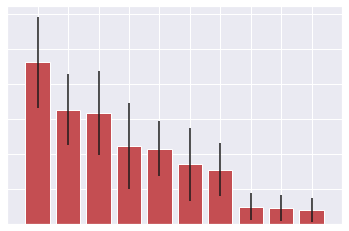

In [52]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# References / Resources

* Bagging (Bootstrap Aggregating)

    * https://en.wikipedia.org/wiki/Bootstrap_aggregating

* Forests: Bagged Trees

    * http://www2.stat.duke.edu/~rcs46/lectures_2017/08-trees/08-tree-advanced.pdf

    * https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

    * https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

* GridSearchCV

    * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

* Bayesian Optimization

    * https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

    * https://www.electricbrain.io/post/learning-to-optimize

    * https://github.com/hyperopt/hyperopt